In [ ]:
## **0. Install Required Libraries**
# pip install numpy==1.23.5
# pip install --upgrade gensim
# pip install --upgrade pythainlp
# pip install emoji
pip install xgboost
pip install optuna  # สำหรับ hyperparameter tuning

## **1. Import Libraries**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
import warnings
warnings.filterwarnings('ignore')

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter
import xgboost as xgb

## **2. Load and Explore Data**
# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)

# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

## **3. Load Thai2Vec Model and Create Vectorization Function**
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    """ปรับปรุงการสร้าง sentence vector ให้เหมาะกับ XGBoost"""
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    if total_words == 0:
        return vec

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words and len(word) > 1]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ - ปรับปรุงให้เหมาะกับ XGBoost"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),
        'question_count': text.count('?'),
        'sentence_count': max(text.count('.') + 1, 1),
        'word_count': word_count,
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),
        'text_length': len(text)
    }

    # คุณลักษณะเพิ่มเติมสำหรับ XGBoost
    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['negation_ratio'] = features['negation_count'] / max(word_count, 1)

    # คุณลักษณะทางสถิติ
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)
    
    # คุณลักษณะเฉพาะสำหรับรีวิวหอพัก
    positive_words = ['ดี', 'สะอาด', 'สวย', 'สบาย', 'ชอบ', 'ประทับใจ', 'คุ้ม', 'เยี่ยม']
    negative_words = ['แย่', 'เหม็น', 'สกปรก', 'พัง', 'แพง', 'ไม่ชอบ', 'ผิดหวัง', 'ไม่คุ้ม']
    
    features['positive_word_count'] = sum(1 for word in words if word in positive_words)
    features['negative_word_count'] = sum(1 for word in words if word in negative_words)
    
    # อัตราส่วนคำบวก/ลบ
    features['positive_ratio'] = features['positive_word_count'] / max(word_count, 1)
    features['negative_ratio'] = features['negative_word_count'] / max(word_count, 1)
    
    # ความหลากหลายของคำ
    features['unique_words_ratio'] = len(set(words)) / max(word_count, 1)

    return features

## **5. Data Cleaning and Preprocessing**
print("กำลังทำความสะอาดข้อมูล...")
df['cleaned_review'] = df['text'].apply(clean_text)

# กรองข้อมูลที่ไม่เหมาะสม
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]
df = df.drop_duplicates(subset=['cleaned_review'])

# สร้าง features
feature_columns = ['cleaned_review']
feature_names = [
    'exclamation_count', 'question_count', 'sentence_count', 'word_count',
    'avg_word_length', 'repeated_words_ratio', 'negation_count', 'negation_ratio',
    'punctuation_ratio', 'text_length', 'words_per_sentence',
    'positive_word_count', 'negative_word_count', 'positive_ratio', 
    'negative_ratio', 'unique_words_ratio'
]

print("กำลังสกัดคุณลักษณะ...")
for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])

feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

## **6. Split Data**
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

# แสดงการกระจายข้อมูล
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))

## **7. Create Feature Vectors**
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

print("กำลังสร้าง Thai2fit vectors...")
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

print("กำลังสร้าง TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    max_features=8000,  # เพิ่มจำนวน features สำหรับ XGBoost
    ngram_range=(1, 3),
    min_df=2, 
    max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

print("กำลังสร้าง Count vectors...")
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=4000,  # เพิ่มจำนวน features
    ngram_range=(1, 2),
    min_df=3, 
    max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# เตรียม features สำหรับ XGBoost
print("กำลังเตรียม features สำหรับ XGBoost...")

# สำหรับ XGBoost เราจะแปลง sparse matrices เป็น dense arrays
# หรือใช้ sparse matrix โดยตรง (XGBoost รองรับ)
numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

# ปรับมาตราส่วน features เพิ่มเติม
features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")

## **8. Combine All Features for XGBoost**
print("กำลังรวม features...")

# สำหรับ XGBoost เราจะรวม features ทั้งหมดเป็น dense matrix
X_train_combined = np.hstack([
    X_train_tfidf.toarray(),           # TF-IDF features (dense)
    X_train_count.toarray(),           # Count vectors (dense)
    X_train_vectors,                   # Thai2fit embeddings
    X_train_additional_scaled          # คุณลักษณะเพิ่มเติม
])

X_test_combined = np.hstack([
    X_test_tfidf.toarray(),
    X_test_count.toarray(),
    X_test_vectors,
    X_test_additional_scaled
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

## **9. Train XGBoost Model**
print("กำลังฝึก XGBoost model...")

# แปลง labels ให้เริ่มจาก 0 (XGBoost requirement)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train - 1)  # 1-5 -> 0-4
y_test_encoded = label_encoder.transform(y_test - 1)

# กำหนดพารามิเตอร์ XGBoost ที่เหมาะสำหรับ multiclass classification
xgb_params = {
    'objective': 'multi:softprob',      # สำหรับ multiclass classification
    'num_class': 5,                     # จำนวนคลาส (1-5 stars)
    'max_depth': 6,                     # ความลึกของต้นไม้
    'learning_rate': 0.1,               # อัตราการเรียนรู้
    'n_estimators': 200,                # จำนวนต้นไม้
    'subsample': 0.8,                   # อัตราส่วนการสุ่มตัวอย่าง
    'colsample_bytree': 0.8,            # อัตราส่วนการสุ่ม features
    'random_state': 42,
    'n_jobs': -1,                       # ใช้ทุก CPU cores
    'reg_alpha': 0.1,                   # L1 regularization
    'reg_lambda': 1.0,                  # L2 regularization
    'min_child_weight': 1,
    'gamma': 0.1,
    'scale_pos_weight': 1,
    'eval_metric': 'mlogloss'           # metric สำหรับ multiclass
}

# สร้างและฝึก XGBoost model
xgb_model = xgb.XGBClassifier(**xgb_params)

start_time = time.time()
xgb_model.fit(
    X_train_combined, 
    y_train_encoded,
    eval_set=[(X_test_combined, y_test_encoded)],
    early_stopping_rounds=20,
    verbose=False
)
training_time = time.time() - start_time

print(f"เวลาในการฝึกโมเดล: {training_time:.2f} วินาที")

## **10. Evaluate Model**
print("กำลังประเมินโมเดล...")

# ทำนายผลลัพธ์
y_pred_encoded = xgb_model.predict(X_test_combined)
y_pred = y_pred_encoded + 1  # แปลงกลับเป็น 1-5

# คำนวณความแม่นยำ
accuracy = accuracy_score(y_test, y_pred)

print(f"\nXGBoost Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation
print("กำลังทำ Cross-Validation...")
cv_scores = cross_val_score(
    xgb_model, X_train_combined, y_train_encoded, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy'
)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("XGBoost Confusion Matrix")
plt.savefig("xgboost_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
print("\nTop 20 Important Features:")
feature_names_all = (
    [f'tfidf_{i}' for i in range(X_train_tfidf.shape[1])] +
    [f'count_{i}' for i in range(X_train_count.shape[1])] +
    [f'thai2fit_{i}' for i in range(X_train_vectors.shape[1])] +
    numerical_features
)

feature_importance = pd.DataFrame({
    'feature': feature_names_all,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# แสดงกราฟ Feature Importance สำหรับ features เพิ่มเติม
additional_feature_importance = feature_importance[
    feature_importance['feature'].isin(numerical_features)
].head(10)

plt.figure(figsize=(10, 6))
plt.barh(additional_feature_importance['feature'], additional_feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top Additional Features Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("xgboost_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

## **11. Create Enhanced Prediction Function**
def predict_review_xgboost(text, model, tfidf_vectorizer, count_vectorizer, features_scaler, label_encoder):
    """ฟังก์ชันทำนายสำหรับ XGBoost model"""
    try:
        # ทำความสะอาดข้อความ
        cleaned_text = clean_text(text)
        
        if not cleaned_text.strip():
            return None, None
        
        # สกัดคุณลักษณะทางสถิติ
        features = extract_features(cleaned_text)
        
        # สร้าง Thai2fit vectors
        review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
        
        # สร้าง TF-IDF vectors
        review_tfidf = tfidf_vectorizer.transform([cleaned_text])
        
        # สร้าง Count vectors
        review_count = count_vectorizer.transform([cleaned_text])
        
        # สร้าง statistical feature vectors
        additional_features = np.array([[
            features['exclamation_count'],
            features['question_count'],
            features['sentence_count'],
            features['word_count'],
            features['avg_word_length'],
            features['repeated_words_ratio'],
            features['negation_count'],
            features['negation_ratio'],
            features['punctuation_ratio'],
            features['text_length'],
            features['words_per_sentence'],
            features['positive_word_count'],
            features['negative_word_count'],
            features['positive_ratio'],
            features['negative_ratio'],
            features['unique_words_ratio']
        ]])
        
        additional_features_scaled = features_scaler.transform(additional_features)
        
        # รวม features ทั้งหมด
        review_combined = np.hstack([
            review_tfidf.toarray(),
            review_count.toarray(),
            review_vector,
            additional_features_scaled
        ])
        
        # ทำนาย
        predicted_class_encoded = model.predict(review_combined)[0]
        predicted_class = predicted_class_encoded + 1  # แปลงกลับเป็น 1-5
        
        # ความน่าจะเป็น
        probabilities = model.predict_proba(review_combined)[0]
        
        return predicted_class, probabilities
        
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, None

## **12. Test with Real Reviews**
def print_prediction_results_xgboost(text, actual_rating, model, tfidf_vectorizer, count_vectorizer, features_scaler, label_encoder):
    """แสดงผลการทำนายของ XGBoost model"""
    predicted_class, confidences = predict_review_xgboost(
        text, model, tfidf_vectorizer, count_vectorizer, features_scaler, label_encoder
    )
    
    if predicted_class is None:
        print(f"\nไม่สามารถทำนายได้สำหรับข้อความ: {text[:50]}...")
        return None, None
        
    is_correct = int(predicted_class) == int(actual_rating)
    
    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'✓ Correct' if is_correct else '✗ Incorrect'}")
    
    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        marker = "★" if rating == predicted_class else " "
        print(f"  {marker} Star {rating}: {confidence * 100:.1f}%")
    
    return predicted_class, int(actual_rating)

# ตัวอย่างรีวิวสำหรับทดสอบ
print("\n" + "="*50)
print("ทดสอบโมเดล XGBoost กับรีวิวสมจริง:")
print("="*50)

test_reviews = [
    ["หอพักแย่ม๊ากกก เน็ตช้าสัสสส!! ห้องน้ำก็เหม็นอับ แถมเจอแมลงสาบวิ่งทุกวัน ผนังบางเหมือนกระดาษ ได้ยินเสียงข้างห้องตลอด พี่ที่ดูแลหอก็หน้าบึ้งตลอด แจ้งปัญหาทีนึงรอเป็นอาทิตย์กว่าจะมาดูให้ บอกเลยว่าเสียดายเงินสุดๆ ใครจะมาอยู่คิดดีๆนะ T-T", 1],
    ["ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ", 1],
    ["หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ", 2],
    ["ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย", 2],
    ["หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ", 3],
    ["หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น", 3],
    ["ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย", 4],
    ["ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด", 4],
    ["หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!", 5],
    ["ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥", 5]
]

results = []
for i, (review, actual_rating) in enumerate(test_reviews, 1):
    print(f"\n--- ตัวอย่างที่ {i} ---")
    predicted_rating, actual = print_prediction_results_xgboost(
        review, actual_rating, xgb_model, tfidf_vectorizer, count_vectorizer, features_scaler, label_encoder
    )
    if predicted_rating is not None:
        results.append((predicted_rating, actual))

# สรุปผลการทดสอบ
if results:
    correct_predictions = sum(1 for pred, actual in results if pred == actual)
    accuracy = correct_predictions / len(results)
    
    print("\n" + "="*50)
    print("ผลสรุปการทดสอบรีวิว XGBoost:")
    print("="*50)
    print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
    print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
    print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")
    
    # วิเคราะห์ผลลัพธ์ตามคะแนน
    actual_ratings = [actual for _, actual in results]
    predicted_ratings = [pred for pred, _ in results]
    
    print(f"\nความแม่นยำรวมบนชุดทดสอบ: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ความแม่นยำบนตัวอย่างทดสอบ: {accuracy:.4f}")

## **13. Save Model and Components**
import pickle

print("\nกำลังบันทึกโมเดลและ components...")

# บันทึก model และ components
model_components = {
    'xgb_model': xgb_model,
    'tfidf_vectorizer': tfidf_vectorizer,
    'count_vectorizer': count_vectorizer,
    'features_scaler': features_scaler,
    'label_encoder': label_encoder
}

with open('thai_dorm_xgboost_model.pkl', 'wb') as f:
    pickle.dump(model_components, f)

print("บันทึกโมเดลเรียบร้อยแล้ว: thai_dorm_xgboost_model.pkl")

## **14. Function to Load and Use Model**
def load_model_and_predict(review_text, model_path='thai_dorm_xgboost_model.pkl'):
    """โหลดโมเดลและทำนายผลลัพธ์"""
    try:
        # โหลด model และ components
        with open(model_path, 'rb') as f:
            components = pickle.load(f)
        
        # ทำนายผลลัพธ์
        predicted_rating, probabilities = predict_review_xgboost(
            review_text,
            components['xgb_model'],
            components['tfidf_vectorizer'],
            components['count_vectorizer'],
            components['features_scaler'],
            components['label_encoder']
        )
        
        return {
            'predicted_rating': int(predicted_rating),
            'probabilities': {f'{i+1}_star': float(prob) for i, prob in enumerate(probabilities)},
            'confidence': float(max(probabilities))
        }
        
    except Exception as e:
        print(f"Error loading model or predicting: {e}")
        return None

print("\n" + "="*50)
print("โมเดล XGBoost สำหรับวิเคราะห์ความคิดเห็นหอพักภาษาไทยพร้อมใช้งาน!")
print("="*50)
print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Cross-validation Mean Accuracy: {cv_scores.mean():.4f}")
print("ใช้ฟังก์ชัน load_model_and_predict() เพื่อทำนายรีวิวใหม่")

SyntaxError: invalid syntax (4228297428.py, line 2)

## **0. Install Required Libraries**

In [ ]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter

## **2. Load and Explore Data**

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)
df

,text,rating
0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,5
1,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,5
2,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,5
3,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,5
4,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,5
...,...,...
2006,ระบบจองโต๊ะทำงานส่วนตัวในพื้นที่ Co-working Sp...,4
2007,ระบบตู้รับพัสดุอัตโนมัติที่สามารถรับพัสดุได้ตล...,4
2008,เตารีดไอน้ำแบบพกพาที่ให้ยืมฟรีเมื่อต้องการใช้ง...,4
2009,บริการนวดผ่อนคลายที่สามารถนัดหมายให้มานวดในห้อ...,4


In [ ]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 400 รีวิว
คะแนน 2: 401 รีวิว
คะแนน 3: 400 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**

In [ ]:
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**

In [ ]:
# **4. ฟังก์ชันทำความสะอาดและเตรียมข้อมูล**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้ (ไม่ควรลบออก)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว (ลบคำสำคัญออกจากรายการคำหยุด)
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),  # จำนวนเครื่องหมาย !
        'question_count': text.count('?'),  # จำนวนเครื่องหมาย ?
        'sentence_count': text.count('.') + 1,  # จำนวนประโยค
        'word_count': word_count,  # จำนวนคำ
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ
        'text_length': len(text)  # ความยาวของข้อความ
    }

    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธและคุณลักษณะอื่นๆ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    return features

## **5. Data Cleaning and Preprocessing**

In [ ]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(review_text)
    
    # สร้าง features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features
    scaled_features = scaler.transform(combined_features)
    
    # ทำนาย
    prediction = lr_model.predict(scaled_features)[0]
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์
    sentiment = "positive" if prediction == 1 else "negative"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }


In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]  # ตัดข้อความที่สั้นเกินไป
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                'text_length', 'words_per_sentence']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

จำนวนข้อมูลหลังทำความสะอาด: 2002
การกระจายของคะแนนหลังทำความสะอาด:
rating
1    400
2    398
3    400
4    409
5    395
Name: count, dtype: int64


## **6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1601
จำนวนข้อมูลทดสอบ: 401


In [ ]:
# คำนวณจำนวนรีวิวตามคะแนน
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# แสดงตาราง
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
    1             320                80          400
    2             318                80          398
    3             320                80          400
    4             327                82          409
    5             316                79          395
  รวม            1601               401         2002


## **7. Create Feature Vectors**

In [ ]:
# สร้างฟังก์ชันสำหรับ tokenize
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

# สร้าง Thai2fit vectors
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF features
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง Count vectors
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,  # ลดลงจากเดิม
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# ปรับสเกลข้อมูล
scaler = StandardScaler(with_mean=False)  # with_mean=False เพราะเราใช้ sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

C:\Users\Phutawan Chonsakorn\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 10
Total features: 13310


## **8. Combine All Features**

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features รวม - train: (1601, 13310), test: (401, 13310)


## **9. Train Model**

In [ ]:

# ใช้ LogisticRegression เหมือนเดิม แต่ปรับแต่งพารามิเตอร์
lr_model = LogisticRegression(
    C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
    class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
    penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
    solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
    tol=0.0001,                 # เกณฑ์การหยุด
    max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
    random_state=42,            # กำหนดค่า random seed
    multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
    n_jobs=-1                   # ใช้ทุก CPU cores
)

start_time = time.time()
# lr_model.fit(X_train_combined, y_train)
training_time = time.time() - start_time

# ฝึกโมเดล Logistic Regression
# ใช้ X_train_combined เป็นคุณลักษณะนำเข้าและ y_train เป็นค่าเป้าหมาย
lr_model.fit(X_train_combined, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

## **10. Evaluate Model**


Model Accuracy: 0.7855

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.91      0.85        80
           2       0.78      0.71      0.75        80
           3       0.77      0.78      0.77        80
           4       0.75      0.66      0.70        82
           5       0.82      0.87      0.85        79

    accuracy                           0.79       401
   macro avg       0.78      0.79      0.78       401
weighted avg       0.78      0.79      0.78       401



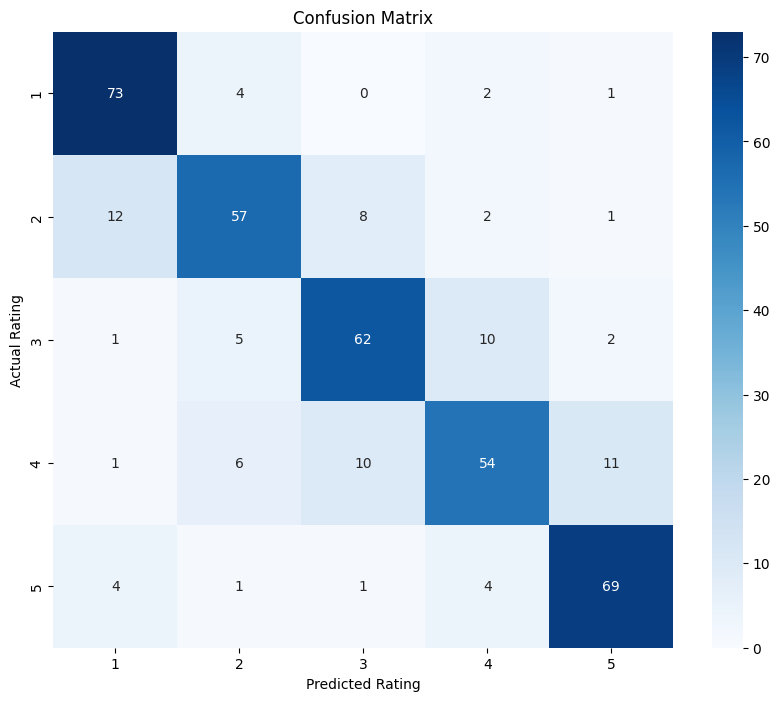

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix")

# บันทึกภาพ
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


## **11. Create Prediction Function**

In [ ]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create prediction function
def predict_review(text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Extract statistical features
    features = extract_features(cleaned_text)
    
    # Create Thai2fit vectors
    review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
    review_vector_sparse = csr_matrix(review_vector)
    review_vector_scaled = scaler.transform(review_vector_sparse)
    
    # Create TF-IDF vectors
    review_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Create Count vectors
    review_count = count_vectorizer.transform([cleaned_text])
    
    # Create statistical feature vectors
    additional_features = np.array([[
        features['exclamation_count'],
        features['question_count'],
        features['sentence_count'],
        features['word_count'],
        features['avg_word_length'],
        features['repeated_words_ratio'],
        features['negation_count'],
        features['punctuation_ratio'],
        features['text_length'],
        features['words_per_sentence']
    ]])
    
    additional_features_scaled = features_scaler.transform(additional_features)
    
    # Combine all features
    review_combined = hstack([
        review_tfidf,
        review_count,
        review_vector_scaled,
        csr_matrix(additional_features_scaled)
    ])
    
    # Predict class and probabilities
    predicted_class = model.predict(review_combined)[0]
    probabilities = model.predict_proba(review_combined)[0]
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**

In [ ]:
# Test with example reviews
def print_prediction_results(
    text,
    actual_rating,
    model,
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    predicted_class, confidences = predict_review(
        text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    is_correct = int(predicted_class) == int(actual_rating)

    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'Correct' if is_correct else 'Incorrect'}")

    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        print(f"  Star {rating}: {confidence * 100:.1f}%")

    return predicted_class, int(actual_rating)


# ตัวอย่างรีวิวสำหรับทดสอบ
print("\nทดสอบโมเดลกับรีวิวสมจริง:")
test_reviews = [
    [
        "ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ",
        1,
    ],
    [
        "หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ",
        2,
    ],
    [
        "ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย",
        2,
    ],
    [
        "หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ",
        3,
    ],
    [
        "หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น",
        3,
    ],
    [
        "ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย",
        4,
    ],
    [
        "ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด",
        4,
    ],
    [
        "หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!",
        5,
    ],
    [
        "ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥",
        5,
    ],
]

results = []
for review, actual_rating in test_reviews:
    predicted_rating, actual = print_prediction_results(
        review,
        actual_rating,
        lr_model,
        tfidf_vectorizer,
        count_vectorizer,
        scaler,
        features_scaler,
    )
    results.append((predicted_rating, actual))

correct_predictions = sum(1 for pred, actual in results if pred == actual)
accuracy = correct_predictions / len(results)

print("\nผลสรุปการทดสอบรีวิว:")
print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")


ทดสอบโมเดลกับรีวิวสมจริง:

Review: ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพ...
Actual rating: 1/5
Predicted rating: 1/5
Result: Correct
Confidence:
  Star 1: 97.7%
  Star 2: 2.3%
  Star 3: 0.0%
  Star 4: 0.0%
  Star 5: 0.0%

Review: หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้อ...
Actual rating: 2/5
Predicted rating: 3/5
Result: Incorrect
Confidence:
  Star 1: 0.5%
  Star 2: 2.3%
  Star 3: 53.3%
  Star 4: 43.9%
  Star 5: 0.0%

Review: ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช...
Actual rating: 2/5
Predicted rating: 2/5
Result: Correct
Confidence:
  Star 1: 25.2%
  Star 2: 67.9%
  Star 3: 5.8%
  Star 4: 1.0%
  Star 5: 0.0%

Review: หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่น...
Actual rating: 3/5
Predicted rating: 2/5
Result: Incorrect
Confidence:
  Star 1: 1

## **0. Install Required Libraries**

## **0. Install Required Libraries**

## **0. Install Required Libraries**

## **0. Install Required Libraries**

## **0. Install Required Libraries**

In [ ]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter

## **2. Load and Explore Data**

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)
df

,text,rating
0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,5
1,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,5
2,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,5
3,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,5
4,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,5
...,...,...
2006,ระบบจองโต๊ะทำงานส่วนตัวในพื้นที่ Co-working Sp...,4
2007,ระบบตู้รับพัสดุอัตโนมัติที่สามารถรับพัสดุได้ตล...,4
2008,เตารีดไอน้ำแบบพกพาที่ให้ยืมฟรีเมื่อต้องการใช้ง...,4
2009,บริการนวดผ่อนคลายที่สามารถนัดหมายให้มานวดในห้อ...,4


In [ ]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 400 รีวิว
คะแนน 2: 401 รีวิว
คะแนน 3: 400 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**

In [ ]:
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**

In [ ]:
# **4. ฟังก์ชันทำความสะอาดและเตรียมข้อมูล**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้ (ไม่ควรลบออก)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว (ลบคำสำคัญออกจากรายการคำหยุด)
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),  # จำนวนเครื่องหมาย !
        'question_count': text.count('?'),  # จำนวนเครื่องหมาย ?
        'sentence_count': text.count('.') + 1,  # จำนวนประโยค
        'word_count': word_count,  # จำนวนคำ
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ
        'text_length': len(text)  # ความยาวของข้อความ
    }

    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธและคุณลักษณะอื่นๆ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    return features

## **5. Data Cleaning and Preprocessing**

In [ ]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(review_text)
    
    # สร้าง features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features
    scaled_features = scaler.transform(combined_features)
    
    # ทำนาย
    prediction = lr_model.predict(scaled_features)[0]
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์
    sentiment = "positive" if prediction == 1 else "negative"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }


In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]  # ตัดข้อความที่สั้นเกินไป
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                'text_length', 'words_per_sentence']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

จำนวนข้อมูลหลังทำความสะอาด: 2002
การกระจายของคะแนนหลังทำความสะอาด:
rating
1    400
2    398
3    400
4    409
5    395
Name: count, dtype: int64


## **6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1601
จำนวนข้อมูลทดสอบ: 401


In [ ]:
# คำนวณจำนวนรีวิวตามคะแนน
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# แสดงตาราง
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
    1             320                80          400
    2             318                80          398
    3             320                80          400
    4             327                82          409
    5             316                79          395
  รวม            1601               401         2002


## **7. Create Feature Vectors**

In [ ]:
# สร้างฟังก์ชันสำหรับ tokenize
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

# สร้าง Thai2fit vectors
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF features
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง Count vectors
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,  # ลดลงจากเดิม
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# ปรับสเกลข้อมูล
scaler = StandardScaler(with_mean=False)  # with_mean=False เพราะเราใช้ sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

C:\Users\Phutawan Chonsakorn\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 10
Total features: 13310


## **8. Combine All Features**

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features รวม - train: (1601, 13310), test: (401, 13310)


## **9. Train Model**

In [ ]:

# ใช้ LogisticRegression เหมือนเดิม แต่ปรับแต่งพารามิเตอร์
lr_model = LogisticRegression(
    C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
    class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
    penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
    solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
    tol=0.0001,                 # เกณฑ์การหยุด
    max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
    random_state=42,            # กำหนดค่า random seed
    multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
    n_jobs=-1                   # ใช้ทุก CPU cores
)

start_time = time.time()
# lr_model.fit(X_train_combined, y_train)
training_time = time.time() - start_time

# ฝึกโมเดล Logistic Regression
# ใช้ X_train_combined เป็นคุณลักษณะนำเข้าและ y_train เป็นค่าเป้าหมาย
lr_model.fit(X_train_combined, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

## **10. Evaluate Model**


Model Accuracy: 0.7855

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.91      0.85        80
           2       0.78      0.71      0.75        80
           3       0.77      0.78      0.77        80
           4       0.75      0.66      0.70        82
           5       0.82      0.87      0.85        79

    accuracy                           0.79       401
   macro avg       0.78      0.79      0.78       401
weighted avg       0.78      0.79      0.78       401



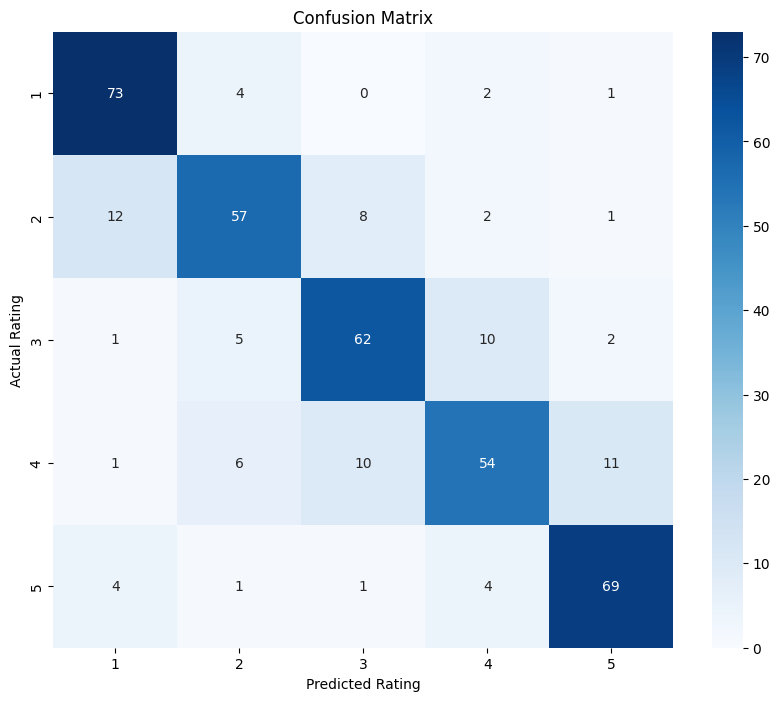

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix")

# บันทึกภาพ
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


## **11. Create Prediction Function**

In [ ]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create prediction function
def predict_review(text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Extract statistical features
    features = extract_features(cleaned_text)
    
    # Create Thai2fit vectors
    review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
    review_vector_sparse = csr_matrix(review_vector)
    review_vector_scaled = scaler.transform(review_vector_sparse)
    
    # Create TF-IDF vectors
    review_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Create Count vectors
    review_count = count_vectorizer.transform([cleaned_text])
    
    # Create statistical feature vectors
    additional_features = np.array([[
        features['exclamation_count'],
        features['question_count'],
        features['sentence_count'],
        features['word_count'],
        features['avg_word_length'],
        features['repeated_words_ratio'],
        features['negation_count'],
        features['punctuation_ratio'],
        features['text_length'],
        features['words_per_sentence']
    ]])
    
    additional_features_scaled = features_scaler.transform(additional_features)
    
    # Combine all features
    review_combined = hstack([
        review_tfidf,
        review_count,
        review_vector_scaled,
        csr_matrix(additional_features_scaled)
    ])
    
    # Predict class and probabilities
    predicted_class = model.predict(review_combined)[0]
    probabilities = model.predict_proba(review_combined)[0]
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**

In [ ]:
# Test with example reviews
def print_prediction_results(
    text,
    actual_rating,
    model,
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    predicted_class, confidences = predict_review(
        text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    is_correct = int(predicted_class) == int(actual_rating)

    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'Correct' if is_correct else 'Incorrect'}")

    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        print(f"  Star {rating}: {confidence * 100:.1f}%")

    return predicted_class, int(actual_rating)


# ตัวอย่างรีวิวสำหรับทดสอบ
print("\nทดสอบโมเดลกับรีวิวสมจริง:")
test_reviews = [
    [
        "ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ",
        1,
    ],
    [
        "หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ",
        2,
    ],
    [
        "ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย",
        2,
    ],
    [
        "หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ",
        3,
    ],
    [
        "หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น",
        3,
    ],
    [
        "ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย",
        4,
    ],
    [
        "ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด",
        4,
    ],
    [
        "หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!",
        5,
    ],
    [
        "ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥",
        5,
    ],
]

results = []
for review, actual_rating in test_reviews:
    predicted_rating, actual = print_prediction_results(
        review,
        actual_rating,
        lr_model,
        tfidf_vectorizer,
        count_vectorizer,
        scaler,
        features_scaler,
    )
    results.append((predicted_rating, actual))

correct_predictions = sum(1 for pred, actual in results if pred == actual)
accuracy = correct_predictions / len(results)

print("\nผลสรุปการทดสอบรีวิว:")
print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")


ทดสอบโมเดลกับรีวิวสมจริง:

Review: ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพ...
Actual rating: 1/5
Predicted rating: 1/5
Result: Correct
Confidence:
  Star 1: 97.7%
  Star 2: 2.3%
  Star 3: 0.0%
  Star 4: 0.0%
  Star 5: 0.0%

Review: หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้อ...
Actual rating: 2/5
Predicted rating: 3/5
Result: Incorrect
Confidence:
  Star 1: 0.5%
  Star 2: 2.3%
  Star 3: 53.3%
  Star 4: 43.9%
  Star 5: 0.0%

Review: ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช...
Actual rating: 2/5
Predicted rating: 2/5
Result: Correct
Confidence:
  Star 1: 25.2%
  Star 2: 67.9%
  Star 3: 5.8%
  Star 4: 1.0%
  Star 5: 0.0%

Review: หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่น...
Actual rating: 3/5
Predicted rating: 2/5
Result: Incorrect
Confidence:
  Star 1: 1

In [ ]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter

## **2. Load and Explore Data**

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)
df

,text,rating
0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,5
1,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,5
2,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,5
3,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,5
4,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,5
...,...,...
2006,ระบบจองโต๊ะทำงานส่วนตัวในพื้นที่ Co-working Sp...,4
2007,ระบบตู้รับพัสดุอัตโนมัติที่สามารถรับพัสดุได้ตล...,4
2008,เตารีดไอน้ำแบบพกพาที่ให้ยืมฟรีเมื่อต้องการใช้ง...,4
2009,บริการนวดผ่อนคลายที่สามารถนัดหมายให้มานวดในห้อ...,4


In [ ]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 400 รีวิว
คะแนน 2: 401 รีวิว
คะแนน 3: 400 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**

In [ ]:
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**

In [ ]:
# **4. ฟังก์ชันทำความสะอาดและเตรียมข้อมูล**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้ (ไม่ควรลบออก)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว (ลบคำสำคัญออกจากรายการคำหยุด)
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),  # จำนวนเครื่องหมาย !
        'question_count': text.count('?'),  # จำนวนเครื่องหมาย ?
        'sentence_count': text.count('.') + 1,  # จำนวนประโยค
        'word_count': word_count,  # จำนวนคำ
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ
        'text_length': len(text)  # ความยาวของข้อความ
    }

    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธและคุณลักษณะอื่นๆ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    return features

## **5. Data Cleaning and Preprocessing**

In [ ]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(review_text)
    
    # สร้าง features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features
    scaled_features = scaler.transform(combined_features)
    
    # ทำนาย
    prediction = lr_model.predict(scaled_features)[0]
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์
    sentiment = "positive" if prediction == 1 else "negative"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }


In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]  # ตัดข้อความที่สั้นเกินไป
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                'text_length', 'words_per_sentence']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

จำนวนข้อมูลหลังทำความสะอาด: 2002
การกระจายของคะแนนหลังทำความสะอาด:
rating
1    400
2    398
3    400
4    409
5    395
Name: count, dtype: int64


## **6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1601
จำนวนข้อมูลทดสอบ: 401


In [ ]:
# คำนวณจำนวนรีวิวตามคะแนน
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# แสดงตาราง
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
    1             320                80          400
    2             318                80          398
    3             320                80          400
    4             327                82          409
    5             316                79          395
  รวม            1601               401         2002


## **7. Create Feature Vectors**

In [ ]:
# สร้างฟังก์ชันสำหรับ tokenize
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

# สร้าง Thai2fit vectors
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF features
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง Count vectors
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,  # ลดลงจากเดิม
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# ปรับสเกลข้อมูล
scaler = StandardScaler(with_mean=False)  # with_mean=False เพราะเราใช้ sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

C:\Users\Phutawan Chonsakorn\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 10
Total features: 13310


## **8. Combine All Features**

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features รวม - train: (1601, 13310), test: (401, 13310)


## **9. Train Model**

In [ ]:

# ใช้ LogisticRegression เหมือนเดิม แต่ปรับแต่งพารามิเตอร์
lr_model = LogisticRegression(
    C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
    class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
    penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
    solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
    tol=0.0001,                 # เกณฑ์การหยุด
    max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
    random_state=42,            # กำหนดค่า random seed
    multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
    n_jobs=-1                   # ใช้ทุก CPU cores
)

start_time = time.time()
# lr_model.fit(X_train_combined, y_train)
training_time = time.time() - start_time

# ฝึกโมเดล Logistic Regression
# ใช้ X_train_combined เป็นคุณลักษณะนำเข้าและ y_train เป็นค่าเป้าหมาย
lr_model.fit(X_train_combined, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

## **10. Evaluate Model**


Model Accuracy: 0.7855

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.91      0.85        80
           2       0.78      0.71      0.75        80
           3       0.77      0.78      0.77        80
           4       0.75      0.66      0.70        82
           5       0.82      0.87      0.85        79

    accuracy                           0.79       401
   macro avg       0.78      0.79      0.78       401
weighted avg       0.78      0.79      0.78       401



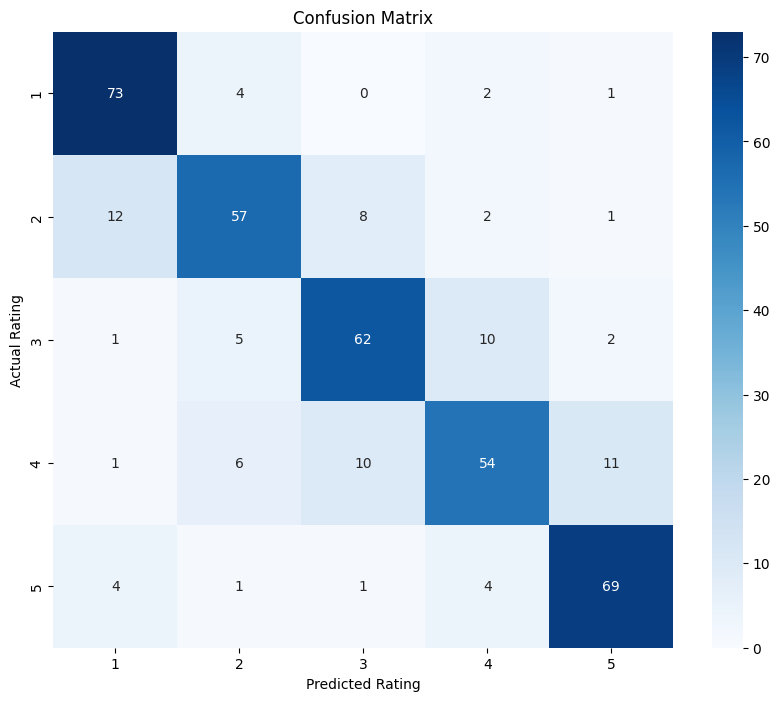

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix")

# บันทึกภาพ
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


## **11. Create Prediction Function**

In [ ]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create prediction function
def predict_review(text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Extract statistical features
    features = extract_features(cleaned_text)
    
    # Create Thai2fit vectors
    review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
    review_vector_sparse = csr_matrix(review_vector)
    review_vector_scaled = scaler.transform(review_vector_sparse)
    
    # Create TF-IDF vectors
    review_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Create Count vectors
    review_count = count_vectorizer.transform([cleaned_text])
    
    # Create statistical feature vectors
    additional_features = np.array([[
        features['exclamation_count'],
        features['question_count'],
        features['sentence_count'],
        features['word_count'],
        features['avg_word_length'],
        features['repeated_words_ratio'],
        features['negation_count'],
        features['punctuation_ratio'],
        features['text_length'],
        features['words_per_sentence']
    ]])
    
    additional_features_scaled = features_scaler.transform(additional_features)
    
    # Combine all features
    review_combined = hstack([
        review_tfidf,
        review_count,
        review_vector_scaled,
        csr_matrix(additional_features_scaled)
    ])
    
    # Predict class and probabilities
    predicted_class = model.predict(review_combined)[0]
    probabilities = model.predict_proba(review_combined)[0]
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**

In [ ]:
# Test with example reviews
def print_prediction_results(
    text,
    actual_rating,
    model,
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    predicted_class, confidences = predict_review(
        text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    is_correct = int(predicted_class) == int(actual_rating)

    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'Correct' if is_correct else 'Incorrect'}")

    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        print(f"  Star {rating}: {confidence * 100:.1f}%")

    return predicted_class, int(actual_rating)


# ตัวอย่างรีวิวสำหรับทดสอบ
print("\nทดสอบโมเดลกับรีวิวสมจริง:")
test_reviews = [
    [
        "ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ",
        1,
    ],
    [
        "หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ",
        2,
    ],
    [
        "ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย",
        2,
    ],
    [
        "หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ",
        3,
    ],
    [
        "หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น",
        3,
    ],
    [
        "ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย",
        4,
    ],
    [
        "ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด",
        4,
    ],
    [
        "หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!",
        5,
    ],
    [
        "ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥",
        5,
    ],
]

results = []
for review, actual_rating in test_reviews:
    predicted_rating, actual = print_prediction_results(
        review,
        actual_rating,
        lr_model,
        tfidf_vectorizer,
        count_vectorizer,
        scaler,
        features_scaler,
    )
    results.append((predicted_rating, actual))

correct_predictions = sum(1 for pred, actual in results if pred == actual)
accuracy = correct_predictions / len(results)

print("\nผลสรุปการทดสอบรีวิว:")
print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")


ทดสอบโมเดลกับรีวิวสมจริง:

Review: ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพ...
Actual rating: 1/5
Predicted rating: 1/5
Result: Correct
Confidence:
  Star 1: 97.7%
  Star 2: 2.3%
  Star 3: 0.0%
  Star 4: 0.0%
  Star 5: 0.0%

Review: หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้อ...
Actual rating: 2/5
Predicted rating: 3/5
Result: Incorrect
Confidence:
  Star 1: 0.5%
  Star 2: 2.3%
  Star 3: 53.3%
  Star 4: 43.9%
  Star 5: 0.0%

Review: ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช...
Actual rating: 2/5
Predicted rating: 2/5
Result: Correct
Confidence:
  Star 1: 25.2%
  Star 2: 67.9%
  Star 3: 5.8%
  Star 4: 1.0%
  Star 5: 0.0%

Review: หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่น...
Actual rating: 3/5
Predicted rating: 2/5
Result: Incorrect
Confidence:
  Star 1: 1

In [ ]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter

## **2. Load and Explore Data**

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)
df

,text,rating
0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,5
1,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,5
2,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,5
3,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,5
4,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,5
...,...,...
2006,ระบบจองโต๊ะทำงานส่วนตัวในพื้นที่ Co-working Sp...,4
2007,ระบบตู้รับพัสดุอัตโนมัติที่สามารถรับพัสดุได้ตล...,4
2008,เตารีดไอน้ำแบบพกพาที่ให้ยืมฟรีเมื่อต้องการใช้ง...,4
2009,บริการนวดผ่อนคลายที่สามารถนัดหมายให้มานวดในห้อ...,4


In [ ]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 400 รีวิว
คะแนน 2: 401 รีวิว
คะแนน 3: 400 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**

In [ ]:
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**

In [ ]:
# **4. ฟังก์ชันทำความสะอาดและเตรียมข้อมูล**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้ (ไม่ควรลบออก)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว (ลบคำสำคัญออกจากรายการคำหยุด)
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),  # จำนวนเครื่องหมาย !
        'question_count': text.count('?'),  # จำนวนเครื่องหมาย ?
        'sentence_count': text.count('.') + 1,  # จำนวนประโยค
        'word_count': word_count,  # จำนวนคำ
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ
        'text_length': len(text)  # ความยาวของข้อความ
    }

    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธและคุณลักษณะอื่นๆ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    return features

## **5. Data Cleaning and Preprocessing**

In [ ]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(review_text)
    
    # สร้าง features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features
    scaled_features = scaler.transform(combined_features)
    
    # ทำนาย
    prediction = lr_model.predict(scaled_features)[0]
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์
    sentiment = "positive" if prediction == 1 else "negative"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }


In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]  # ตัดข้อความที่สั้นเกินไป
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                'text_length', 'words_per_sentence']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

จำนวนข้อมูลหลังทำความสะอาด: 2002
การกระจายของคะแนนหลังทำความสะอาด:
rating
1    400
2    398
3    400
4    409
5    395
Name: count, dtype: int64


## **6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1601
จำนวนข้อมูลทดสอบ: 401


In [ ]:
# คำนวณจำนวนรีวิวตามคะแนน
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# แสดงตาราง
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
    1             320                80          400
    2             318                80          398
    3             320                80          400
    4             327                82          409
    5             316                79          395
  รวม            1601               401         2002


## **7. Create Feature Vectors**

In [ ]:
# สร้างฟังก์ชันสำหรับ tokenize
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

# สร้าง Thai2fit vectors
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF features
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง Count vectors
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,  # ลดลงจากเดิม
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# ปรับสเกลข้อมูล
scaler = StandardScaler(with_mean=False)  # with_mean=False เพราะเราใช้ sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

C:\Users\Phutawan Chonsakorn\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 10
Total features: 13310


## **8. Combine All Features**

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features รวม - train: (1601, 13310), test: (401, 13310)


## **9. Train Model**

In [ ]:

# ใช้ LogisticRegression เหมือนเดิม แต่ปรับแต่งพารามิเตอร์
lr_model = LogisticRegression(
    C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
    class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
    penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
    solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
    tol=0.0001,                 # เกณฑ์การหยุด
    max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
    random_state=42,            # กำหนดค่า random seed
    multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
    n_jobs=-1                   # ใช้ทุก CPU cores
)

start_time = time.time()
# lr_model.fit(X_train_combined, y_train)
training_time = time.time() - start_time

# ฝึกโมเดล Logistic Regression
# ใช้ X_train_combined เป็นคุณลักษณะนำเข้าและ y_train เป็นค่าเป้าหมาย
lr_model.fit(X_train_combined, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

## **10. Evaluate Model**


Model Accuracy: 0.7855

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.91      0.85        80
           2       0.78      0.71      0.75        80
           3       0.77      0.78      0.77        80
           4       0.75      0.66      0.70        82
           5       0.82      0.87      0.85        79

    accuracy                           0.79       401
   macro avg       0.78      0.79      0.78       401
weighted avg       0.78      0.79      0.78       401



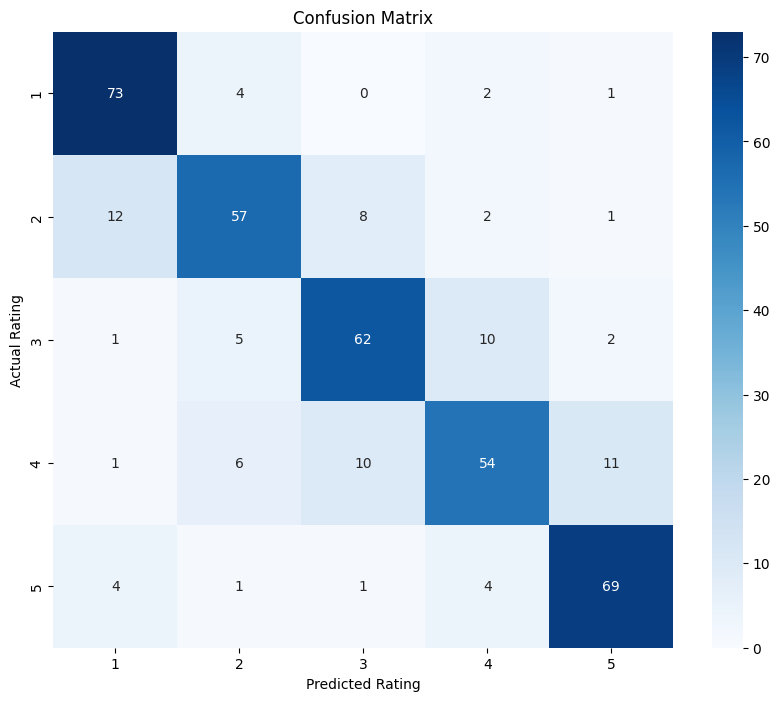

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix")

# บันทึกภาพ
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


## **11. Create Prediction Function**

In [ ]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create prediction function
def predict_review(text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Extract statistical features
    features = extract_features(cleaned_text)
    
    # Create Thai2fit vectors
    review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
    review_vector_sparse = csr_matrix(review_vector)
    review_vector_scaled = scaler.transform(review_vector_sparse)
    
    # Create TF-IDF vectors
    review_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Create Count vectors
    review_count = count_vectorizer.transform([cleaned_text])
    
    # Create statistical feature vectors
    additional_features = np.array([[
        features['exclamation_count'],
        features['question_count'],
        features['sentence_count'],
        features['word_count'],
        features['avg_word_length'],
        features['repeated_words_ratio'],
        features['negation_count'],
        features['punctuation_ratio'],
        features['text_length'],
        features['words_per_sentence']
    ]])
    
    additional_features_scaled = features_scaler.transform(additional_features)
    
    # Combine all features
    review_combined = hstack([
        review_tfidf,
        review_count,
        review_vector_scaled,
        csr_matrix(additional_features_scaled)
    ])
    
    # Predict class and probabilities
    predicted_class = model.predict(review_combined)[0]
    probabilities = model.predict_proba(review_combined)[0]
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**

In [ ]:
# Test with example reviews
def print_prediction_results(
    text,
    actual_rating,
    model,
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    predicted_class, confidences = predict_review(
        text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    is_correct = int(predicted_class) == int(actual_rating)

    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'Correct' if is_correct else 'Incorrect'}")

    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        print(f"  Star {rating}: {confidence * 100:.1f}%")

    return predicted_class, int(actual_rating)


# ตัวอย่างรีวิวสำหรับทดสอบ
print("\nทดสอบโมเดลกับรีวิวสมจริง:")
test_reviews = [
    [
        "ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ",
        1,
    ],
    [
        "หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ",
        2,
    ],
    [
        "ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย",
        2,
    ],
    [
        "หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ",
        3,
    ],
    [
        "หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น",
        3,
    ],
    [
        "ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย",
        4,
    ],
    [
        "ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด",
        4,
    ],
    [
        "หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!",
        5,
    ],
    [
        "ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥",
        5,
    ],
]

results = []
for review, actual_rating in test_reviews:
    predicted_rating, actual = print_prediction_results(
        review,
        actual_rating,
        lr_model,
        tfidf_vectorizer,
        count_vectorizer,
        scaler,
        features_scaler,
    )
    results.append((predicted_rating, actual))

correct_predictions = sum(1 for pred, actual in results if pred == actual)
accuracy = correct_predictions / len(results)

print("\nผลสรุปการทดสอบรีวิว:")
print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")


ทดสอบโมเดลกับรีวิวสมจริง:

Review: ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพ...
Actual rating: 1/5
Predicted rating: 1/5
Result: Correct
Confidence:
  Star 1: 97.7%
  Star 2: 2.3%
  Star 3: 0.0%
  Star 4: 0.0%
  Star 5: 0.0%

Review: หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้อ...
Actual rating: 2/5
Predicted rating: 3/5
Result: Incorrect
Confidence:
  Star 1: 0.5%
  Star 2: 2.3%
  Star 3: 53.3%
  Star 4: 43.9%
  Star 5: 0.0%

Review: ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช...
Actual rating: 2/5
Predicted rating: 2/5
Result: Correct
Confidence:
  Star 1: 25.2%
  Star 2: 67.9%
  Star 3: 5.8%
  Star 4: 1.0%
  Star 5: 0.0%

Review: หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่น...
Actual rating: 3/5
Predicted rating: 2/5
Result: Incorrect
Confidence:
  Star 1: 1

In [ ]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter

## **2. Load and Explore Data**

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)
df

,text,rating
0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,5
1,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,5
2,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,5
3,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,5
4,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,5
...,...,...
2006,ระบบจองโต๊ะทำงานส่วนตัวในพื้นที่ Co-working Sp...,4
2007,ระบบตู้รับพัสดุอัตโนมัติที่สามารถรับพัสดุได้ตล...,4
2008,เตารีดไอน้ำแบบพกพาที่ให้ยืมฟรีเมื่อต้องการใช้ง...,4
2009,บริการนวดผ่อนคลายที่สามารถนัดหมายให้มานวดในห้อ...,4


In [ ]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 400 รีวิว
คะแนน 2: 401 รีวิว
คะแนน 3: 400 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**

In [ ]:
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**

In [ ]:
# **4. ฟังก์ชันทำความสะอาดและเตรียมข้อมูล**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้ (ไม่ควรลบออก)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว (ลบคำสำคัญออกจากรายการคำหยุด)
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),  # จำนวนเครื่องหมาย !
        'question_count': text.count('?'),  # จำนวนเครื่องหมาย ?
        'sentence_count': text.count('.') + 1,  # จำนวนประโยค
        'word_count': word_count,  # จำนวนคำ
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ
        'text_length': len(text)  # ความยาวของข้อความ
    }

    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธและคุณลักษณะอื่นๆ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    return features

## **5. Data Cleaning and Preprocessing**

In [ ]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(review_text)
    
    # สร้าง features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features
    scaled_features = scaler.transform(combined_features)
    
    # ทำนาย
    prediction = lr_model.predict(scaled_features)[0]
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์
    sentiment = "positive" if prediction == 1 else "negative"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }


In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]  # ตัดข้อความที่สั้นเกินไป
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                'text_length', 'words_per_sentence']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

จำนวนข้อมูลหลังทำความสะอาด: 2002
การกระจายของคะแนนหลังทำความสะอาด:
rating
1    400
2    398
3    400
4    409
5    395
Name: count, dtype: int64


## **6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1601
จำนวนข้อมูลทดสอบ: 401


In [ ]:
# คำนวณจำนวนรีวิวตามคะแนน
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# แสดงตาราง
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
    1             320                80          400
    2             318                80          398
    3             320                80          400
    4             327                82          409
    5             316                79          395
  รวม            1601               401         2002


## **7. Create Feature Vectors**

In [ ]:
# สร้างฟังก์ชันสำหรับ tokenize
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

# สร้าง Thai2fit vectors
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF features
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง Count vectors
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,  # ลดลงจากเดิม
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# ปรับสเกลข้อมูล
scaler = StandardScaler(with_mean=False)  # with_mean=False เพราะเราใช้ sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

C:\Users\Phutawan Chonsakorn\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 10
Total features: 13310


## **8. Combine All Features**

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features รวม - train: (1601, 13310), test: (401, 13310)


## **9. Train Model**

In [ ]:

# ใช้ LogisticRegression เหมือนเดิม แต่ปรับแต่งพารามิเตอร์
lr_model = LogisticRegression(
    C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
    class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
    penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
    solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
    tol=0.0001,                 # เกณฑ์การหยุด
    max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
    random_state=42,            # กำหนดค่า random seed
    multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
    n_jobs=-1                   # ใช้ทุก CPU cores
)

start_time = time.time()
# lr_model.fit(X_train_combined, y_train)
training_time = time.time() - start_time

# ฝึกโมเดล Logistic Regression
# ใช้ X_train_combined เป็นคุณลักษณะนำเข้าและ y_train เป็นค่าเป้าหมาย
lr_model.fit(X_train_combined, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

## **10. Evaluate Model**


Model Accuracy: 0.7855

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.91      0.85        80
           2       0.78      0.71      0.75        80
           3       0.77      0.78      0.77        80
           4       0.75      0.66      0.70        82
           5       0.82      0.87      0.85        79

    accuracy                           0.79       401
   macro avg       0.78      0.79      0.78       401
weighted avg       0.78      0.79      0.78       401



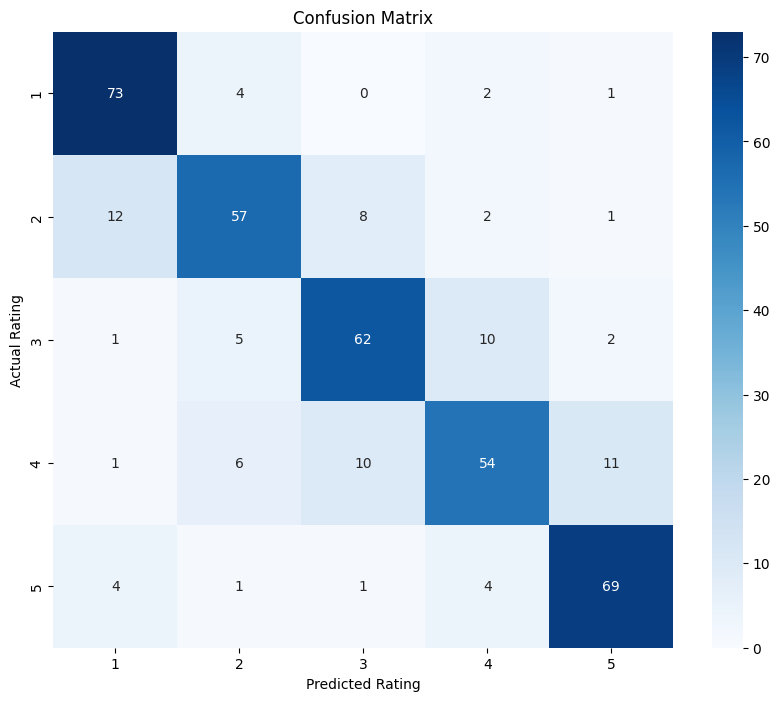

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix")

# บันทึกภาพ
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


## **11. Create Prediction Function**

In [ ]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create prediction function
def predict_review(text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Extract statistical features
    features = extract_features(cleaned_text)
    
    # Create Thai2fit vectors
    review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
    review_vector_sparse = csr_matrix(review_vector)
    review_vector_scaled = scaler.transform(review_vector_sparse)
    
    # Create TF-IDF vectors
    review_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Create Count vectors
    review_count = count_vectorizer.transform([cleaned_text])
    
    # Create statistical feature vectors
    additional_features = np.array([[
        features['exclamation_count'],
        features['question_count'],
        features['sentence_count'],
        features['word_count'],
        features['avg_word_length'],
        features['repeated_words_ratio'],
        features['negation_count'],
        features['punctuation_ratio'],
        features['text_length'],
        features['words_per_sentence']
    ]])
    
    additional_features_scaled = features_scaler.transform(additional_features)
    
    # Combine all features
    review_combined = hstack([
        review_tfidf,
        review_count,
        review_vector_scaled,
        csr_matrix(additional_features_scaled)
    ])
    
    # Predict class and probabilities
    predicted_class = model.predict(review_combined)[0]
    probabilities = model.predict_proba(review_combined)[0]
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**

In [ ]:
# Test with example reviews
def print_prediction_results(
    text,
    actual_rating,
    model,
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    predicted_class, confidences = predict_review(
        text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    is_correct = int(predicted_class) == int(actual_rating)

    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'Correct' if is_correct else 'Incorrect'}")

    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        print(f"  Star {rating}: {confidence * 100:.1f}%")

    return predicted_class, int(actual_rating)


# ตัวอย่างรีวิวสำหรับทดสอบ
print("\nทดสอบโมเดลกับรีวิวสมจริง:")
test_reviews = [
    [
        "ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ",
        1,
    ],
    [
        "หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ",
        2,
    ],
    [
        "ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย",
        2,
    ],
    [
        "หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ",
        3,
    ],
    [
        "หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น",
        3,
    ],
    [
        "ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย",
        4,
    ],
    [
        "ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด",
        4,
    ],
    [
        "หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!",
        5,
    ],
    [
        "ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥",
        5,
    ],
]

results = []
for review, actual_rating in test_reviews:
    predicted_rating, actual = print_prediction_results(
        review,
        actual_rating,
        lr_model,
        tfidf_vectorizer,
        count_vectorizer,
        scaler,
        features_scaler,
    )
    results.append((predicted_rating, actual))

correct_predictions = sum(1 for pred, actual in results if pred == actual)
accuracy = correct_predictions / len(results)

print("\nผลสรุปการทดสอบรีวิว:")
print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")


ทดสอบโมเดลกับรีวิวสมจริง:

Review: ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพ...
Actual rating: 1/5
Predicted rating: 1/5
Result: Correct
Confidence:
  Star 1: 97.7%
  Star 2: 2.3%
  Star 3: 0.0%
  Star 4: 0.0%
  Star 5: 0.0%

Review: หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้อ...
Actual rating: 2/5
Predicted rating: 3/5
Result: Incorrect
Confidence:
  Star 1: 0.5%
  Star 2: 2.3%
  Star 3: 53.3%
  Star 4: 43.9%
  Star 5: 0.0%

Review: ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช...
Actual rating: 2/5
Predicted rating: 2/5
Result: Correct
Confidence:
  Star 1: 25.2%
  Star 2: 67.9%
  Star 3: 5.8%
  Star 4: 1.0%
  Star 5: 0.0%

Review: หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่น...
Actual rating: 3/5
Predicted rating: 2/5
Result: Incorrect
Confidence:
  Star 1: 1

In [ ]:
# !pip install numpy==1.23.5
# !pip install --upgrade gensim
# !pip install --upgrade pythainlp
# !pip install emoji

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import emoji
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_negations
from pythainlp.word_vector import WordVector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
from collections import Counter

## **2. Load and Explore Data**

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

# กำหนดการแสดงผลภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Load dataset
# df = pd.read_csv("/content/drive/MyDrive/CS/DataSet Roomaroo/dorm_reviews.csv")
# โหลดข้อมูลรีวิวหอพัก
df = pd.read_csv("dorm_reviews.csv")
df = df.drop(['dormitory_id', 'user_id'], axis=1)
df

,text,rating
0,อยู่ที่นี่มาจะครบปีแล้วค่ะ ประทับใจมาก หอเงียบ...,5
1,หอคือดีมากแบบ 10/10 ไม่หัก ห้องเหมือนในรูปไม่จ...,5
2,แอร์เย็นน้ำแรง ไม่มีอะไรให้บ่นเลยจริงๆ อยู่มาจ...,5
3,ชอบตรงที่มี working space ใหญ่ๆ ด้านล่าง นั่งท...,5
4,ห้องสะอาดทุกมุม แม่บ้านมาทุกอาทิตย์ เจ้าของหอพ...,5
...,...,...
2006,ระบบจองโต๊ะทำงานส่วนตัวในพื้นที่ Co-working Sp...,4
2007,ระบบตู้รับพัสดุอัตโนมัติที่สามารถรับพัสดุได้ตล...,4
2008,เตารีดไอน้ำแบบพกพาที่ให้ยืมฟรีเมื่อต้องการใช้ง...,4
2009,บริการนวดผ่อนคลายที่สามารถนัดหมายให้มานวดในห้อ...,4


In [ ]:
# แสดงการกระจายของคะแนนรีวิว
rating_counts = df['rating'].value_counts().sort_index()
print("จำนวนรีวิวแต่ละคะแนน:")
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    print(f"คะแนน {rating}: {count} รีวิว")

จำนวนรีวิวแต่ละคะแนน:
คะแนน 1: 400 รีวิว
คะแนน 2: 401 รีวิว
คะแนน 3: 400 รีวิว
คะแนน 4: 410 รีวิว
คะแนน 5: 400 รีวิว


## **3. Load Thai2Vec Model and Create Vectorization Function**

In [ ]:
# thai2fit_wv
thai2fit_model = WordVector(model_name="thai2fit_wv").get_model()

def enhanced_sentence_vectorizer(text, dim=300):
    words = word_tokenize(text, engine="newmm")
    vec = np.zeros(dim)
    word_count = 0
    total_words = len(words)

    for i, word in enumerate(words):
        if word.strip() and word != " ":
            # ถ่วงน้ำหนักตามตำแหน่ง - คำที่อยู่ท้ายประโยคมีน้ำหนักมากกว่า
            position_weight = 1.0 + (i / max(total_words, 1)) * 0.5

            if word in thai2fit_model:
                vec += thai2fit_model[word] * position_weight
                word_count += 1
            else:
                # ถ้าไม่มีคำใน model ลองแตกเป็นตัวอักษร
                char_vec, char_count = np.zeros(dim), 0
                for char in word:
                    if char in thai2fit_model:
                        char_vec += thai2fit_model[char]
                        char_count += 1
                if char_count > 0:
                    vec += (char_vec / char_count) * position_weight
                    word_count += 1

    return vec / max(word_count, 1)  # ป้องกันการหารด้วย 0

## **4. Text Cleaning and Feature Extraction Functions**

In [ ]:
# **4. ฟังก์ชันทำความสะอาดและเตรียมข้อมูล**
def clean_text(text):
    """ทำความสะอาดข้อความก่อนนำไปวิเคราะห์"""
    if not isinstance(text, str):
        return ""

    # เรียกใช้คำหยุดภาษาไทย
    from pythainlp.corpus import thai_stopwords
    thai_stop_words = list(thai_stopwords())

    # คำสำคัญในบริบทหอพัก/ที่พักอาศัย ที่ควรเก็บไว้ (ไม่ควรลบออก)
    important_words = [
        # คำปฏิเสธและเน้นความหมาย
        "ไม่", "ไม่มี", "ไม่ได้", "ไม่ค่อย", "ไม่เคย", "ห้าม", "ยังไม่", "ไม่ยอม",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงบวก)
        "ดี", "ดีมาก", "สะอาด", "เย็น", "กว้าง", "ใหม่", "สวย", "น่าอยู่", "สบาย", "ชอบ", 
        "ประทับใจ", "สะดวก", "ปลอดภัย", "คุ้ม", "คุ้มค่า", "เงียบ", "ครบ", "พอใจ", "เร็ว",
        "โอเค", "โอเคเลย", "เยี่ยม", "ถูกใจ", "ทำเลดี", "ใกล้", "ครบครัน",
        
        # คำแสดงความรู้สึก/คุณภาพ (เชิงลบ)
        "แย่", "ไม่ดี", "เหม็น", "ร้อน", "แคบ", "เก่า", "สกปรก", "พัง", "เสียงดัง", "แพง",
        "ไม่ชอบ", "แออัด", "รก", "อันตราย", "ช้า", "ผิดหวัง", "ห่วย", "เฟล", "กาก",
        "ไม่คุ้ม", "ไกล", "รั่ว", "ทรุด", "ทรุดโทรม", "เสื่อม",
        
        # คำแสดงระดับความเข้ม
        "มาก", "สุดๆ", "เยอะ", "น้อย", "ที่สุด", "หลาย", "ทุก", "เกิน", "จัด", "โคตร",
        "มากๆ", "สุดยอด", "ธรรมดา", "พอใช้", "บ่อย", "ตลอด", "เวอร์",
        
        # อุปกรณ์/สิ่งอำนวยความสะดวก
        "แอร์", "น้ำ", "ไฟ", "ห้องน้ำ", "เตียง", "ฝักบัว", "เน็ต", "ไวไฟ", "ไฟฟ้า", "ประปา",
        "เฟอร์", "ลิฟต์", "ที่จอด", "จอดรถ", "ซักผ้า", "ตู้เย็น", "ทีวี", "จาน", "ไมโครเวฟ", 
        "เตา", "น้ำอุ่น", "ผ้าปู", "โต๊ะ", "เก้าอี้", "ตู้", "ชั้นวาง", "ปลั๊ก", "สัญญาณ",
        
        # สิ่งแวดล้อม
        "เสียง", "มด", "แมลง", "แมลงสาบ", "หนู", "ยุง", "ฝุ่น", "กลิ่น", "เพื่อนบ้าน",
        "ข้างห้อง", "ข้างนอก", "ถนน", "ทางเดิน", "ลานจอด", "ชั้นบน", "บันได", "กำแพง",
        
        # บริการ/การจัดการ
        "ดูแล", "บริการ", "ซ่อม", "แก้ไข", "จัดการ", "พนักงาน", "แม่บ้าน", "รปภ", "เจ้าของ",
        "นิติ", "กฎ", "ระเบียบ", "ค่าเช่า", "ค่าไฟ", "ค่าน้ำ", "ค่าส่วนกลาง", "มัดจำ", "ประกัน", 
        "สัญญา", "ฝากของ", "รับพัสดุ", "คีย์การ์ด", "ล็อค", "รอนาน", "ไม่มาดู", "ไม่ซ่อม",
        
        # คำเชื่อมที่สำคัญในการแสดงความคิดเห็น
        "แต่", "แต่ว่า", "ถึงแม้", "อย่างไรก็ตาม", "เพราะ", "เพราะว่า", "เนื่องจาก", "คือ", "ก็คือ",
        "ส่วน", "นอกจากนี้", "ที่จริง", "จริงๆ", "ก็", "แม้", "ที่", "ตอนแรก", "พอดี", "แล้วก็"
    ]

    # สร้างรายการคำหยุดที่ปรับแต่งแล้ว (ลบคำสำคัญออกจากรายการคำหยุด)
    custom_stop_words = [word for word in thai_stop_words if word not in important_words]

    # เก็บเครื่องหมายสำคัญไว้ใช้เป็นคุณลักษณะ
    punct = string.punctuation.replace('!', '').replace('?', '').replace('.', '')

    # ลบอีโมจิและเครื่องหมายวรรคตอน
    text = emoji.replace_emoji(text, replace="")
    text = ''.join(char if char not in punct else ' ' for char in text)

    # ลดตัวอักษรที่ซ้ำๆ และช่องว่าง
    text = re.sub(r'([ก-๙a-zA-Z])\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', " ", text).strip().lower()

    # ตัดคำและลบคำหยุดภาษาไทย
    words = word_tokenize(text, engine='newmm')
    words = [word for word in words if word not in custom_stop_words]
    text = ' '.join(words)

    return text

def extract_features(text):
    """สกัดคุณลักษณะเพิ่มเติมจากข้อความ"""
    words = word_tokenize(text, engine='newmm')
    word_count = len(words)

    features = {
        'exclamation_count': text.count('!'),  # จำนวนเครื่องหมาย !
        'question_count': text.count('?'),  # จำนวนเครื่องหมาย ?
        'sentence_count': text.count('.') + 1,  # จำนวนประโยค
        'word_count': word_count,  # จำนวนคำ
        'avg_word_length': sum(len(word) for word in words) / max(word_count, 1),  # ความยาวเฉลี่ยของคำ
        'text_length': len(text)  # ความยาวของข้อความ
    }

    # นับคำที่ซ้ำกัน
    word_counts = Counter(words)
    repeated_words = sum(1 for count in word_counts.values() if count > 1)
    features['repeated_words_ratio'] = repeated_words / max(word_count, 1)

    # นับคำปฏิเสธและคุณลักษณะอื่นๆ
    negation_words = thai_negations()
    features['negation_count'] = sum(1 for word in words if word in negation_words)
    features['punctuation_ratio'] = len([c for c in text if c in string.punctuation]) / max(len(text), 1)
    features['words_per_sentence'] = word_count / max(features['sentence_count'], 1)

    return features

## **5. Data Cleaning and Preprocessing**

In [ ]:
# Test with Real Reviews
def predict_sentiment(review_text):
    # ทำความสะอาดข้อความ
    cleaned_text = clean_text(review_text)
    
    # สร้าง features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    count_features = count_vectorizer.transform([cleaned_text])
    
    # รวม features
    combined_features = np.hstack([
        tfidf_features.toarray(),
        count_features.toarray()
    ])
    
    # Scale features
    scaled_features = scaler.transform(combined_features)
    
    # ทำนาย
    prediction = lr_model.predict(scaled_features)[0]
    probability = lr_model.predict_proba(scaled_features)[0]
    
    # แปลงผลลัพธ์
    sentiment = "positive" if prediction == 1 else "negative"
    confidence = probability[1] if prediction == 1 else probability[0]
    
    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability': {
            'negative': float(probability[0]),
            'positive': float(probability[1])
        }
    }


In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)
df = df[df['cleaned_review'].apply(lambda x: len(word_tokenize(x)) > 3)]  # ตัดข้อความที่สั้นเกินไป
df = df.drop_duplicates(subset=['cleaned_review'])

feature_columns = ['cleaned_review']
feature_names = ['exclamation_count', 'question_count', 'sentence_count', 'word_count',
                'avg_word_length', 'repeated_words_ratio', 'negation_count', 'punctuation_ratio',
                'text_length', 'words_per_sentence']

for feature in feature_names:
    df[feature] = df['cleaned_review'].apply(lambda x: extract_features(x)[feature])
feature_columns.extend(feature_names)

print("จำนวนข้อมูลหลังทำความสะอาด:", len(df))
print("การกระจายของคะแนนหลังทำความสะอาด:")
print(df['rating'].value_counts().sort_index())

จำนวนข้อมูลหลังทำความสะอาด: 2002
การกระจายของคะแนนหลังทำความสะอาด:
rating
1    400
2    398
3    400
4    409
5    395
Name: count, dtype: int64


## **6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_columns],
    df['rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"จำนวนข้อมูลฝึกฝน: {len(X_train)}")
print(f"จำนวนข้อมูลทดสอบ: {len(X_test)}")

จำนวนข้อมูลฝึกฝน: 1601
จำนวนข้อมูลทดสอบ: 401


In [ ]:
# คำนวณจำนวนรีวิวตามคะแนน
rating_order = sorted(df['rating'].unique())
train_counts = y_train.value_counts().reindex(rating_order, fill_value=0).tolist()
test_counts = y_test.value_counts().reindex(rating_order, fill_value=0).tolist()
total_counts = [train + test for train, test in zip(train_counts, test_counts)]

# สร้าง DataFrame
table_data = {
    'คะแนน': rating_order,
    'ชุดฝึก (รีวิว)': train_counts,
    'ชุดทดสอบ (รีวิว)': test_counts,
    'รวม (รีวิว)': total_counts
}
table = pd.DataFrame(table_data)

# เพิ่มแถวรวม
table.loc['รวม'] = ['รวม', sum(train_counts), sum(test_counts), sum(total_counts)]

# แสดงตาราง
print("\nการกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ")
print(table.to_string(index=False))


การกระจายคะแนนรีวิวในชุดข้อมูลฝึกและทดสอบ
คะแนน  ชุดฝึก (รีวิว)  ชุดทดสอบ (รีวิว)  รวม (รีวิว)
    1             320                80          400
    2             318                80          398
    3             320                80          400
    4             327                82          409
    5             316                79          395
  รวม            1601               401         2002


## **7. Create Feature Vectors**

In [ ]:
# สร้างฟังก์ชันสำหรับ tokenize
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

# สร้าง Thai2fit vectors
X_train_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_train['cleaned_review']])
X_test_vectors = np.array([enhanced_sentence_vectorizer(text) for text in X_test['cleaned_review']])

# สร้าง TF-IDF features
tfidf_vectorizer = TfidfVectorizer( 
    tokenizer=custom_tokenizer,
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2, max_df=0.85,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# สร้าง Count vectors
count_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=3000,  # ลดลงจากเดิม
    ngram_range=(1, 2),
    min_df=3, max_df=0.85
)

# แปลงข้อมูลด้วย vectorizers
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review'])

X_train_count = count_vectorizer.fit_transform(X_train['cleaned_review'])
X_test_count = count_vectorizer.transform(X_test['cleaned_review'])

# ปรับสเกลข้อมูล
scaler = StandardScaler(with_mean=False)  # with_mean=False เพราะเราใช้ sparse matrix
X_train_vectors_sparse = csr_matrix(X_train_vectors)
X_test_vectors_sparse = csr_matrix(X_test_vectors)

X_train_vectors_scaled = scaler.fit_transform(X_train_vectors_sparse)
X_test_vectors_scaled = scaler.transform(X_test_vectors_sparse)

numerical_features = [col for col in feature_columns if col != 'cleaned_review']
X_train_additional = X_train[numerical_features].values
X_test_additional = X_test[numerical_features].values

features_scaler = StandardScaler()
X_train_additional_scaled = features_scaler.fit_transform(X_train_additional)
X_test_additional_scaled = features_scaler.transform(X_test_additional)

C:\Users\Phutawan Chonsakorn\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Count features: {X_train_count.shape[1]}")
print(f"Thai2fit features: {X_train_vectors.shape[1]}")
print(f"Additional features: {X_train_additional.shape[1]}")
print(f"Total features: {X_train_tfidf.shape[1] + X_train_count.shape[1] + X_train_vectors.shape[1] + X_train_additional.shape[1]}")

TF-IDF features: 10000
Count features: 3000
Thai2fit features: 300
Additional features: 10
Total features: 13310


## **8. Combine All Features**

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,         # TF-IDF features
    X_train_count,         # Count vectors
    X_train_vectors_scaled, # Thai2fit embeddings
    csr_matrix(X_train_additional_scaled) # คุณลักษณะเพิ่มเติม
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_count,
    X_test_vectors_scaled,
    csr_matrix(X_test_additional_scaled)
])

print(f"ขนาดของ features รวม - train: {X_train_combined.shape}, test: {X_test_combined.shape}")

ขนาดของ features รวม - train: (1601, 13310), test: (401, 13310)


## **9. Train Model**

In [ ]:

# ใช้ LogisticRegression เหมือนเดิม แต่ปรับแต่งพารามิเตอร์
lr_model = LogisticRegression(
    C=0.15,                     # ค่า regularization parameter (0.15 ทำให้โมเดลมีความทั่วไปมากขึ้น)
    class_weight='balanced',    # ช่วยจัดการกับข้อมูลที่ไม่สมดุล
    penalty='l2',               # L2 regularization ช่วยป้องกัน overfitting
    solver='saga',              # อัลกอริทึมที่มีประสิทธิภาพดีสำหรับข้อมูลขนาดใหญ่
    tol=0.0001,                 # เกณฑ์การหยุด
    max_iter=1000,              # เพิ่มจำนวนรอบการฝึก
    random_state=42,            # กำหนดค่า random seed
    multi_class='multinomial',  # เป็นโมเดลจำแนกหลายคลาส (multiclass)
    n_jobs=-1                   # ใช้ทุก CPU cores
)

start_time = time.time()
# lr_model.fit(X_train_combined, y_train)
training_time = time.time() - start_time

# ฝึกโมเดล Logistic Regression
# ใช้ X_train_combined เป็นคุณลักษณะนำเข้าและ y_train เป็นค่าเป้าหมาย
lr_model.fit(X_train_combined, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

## **10. Evaluate Model**


Model Accuracy: 0.7855

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.91      0.85        80
           2       0.78      0.71      0.75        80
           3       0.77      0.78      0.77        80
           4       0.75      0.66      0.70        82
           5       0.82      0.87      0.85        79

    accuracy                           0.79       401
   macro avg       0.78      0.79      0.78       401
weighted avg       0.78      0.79      0.78       401



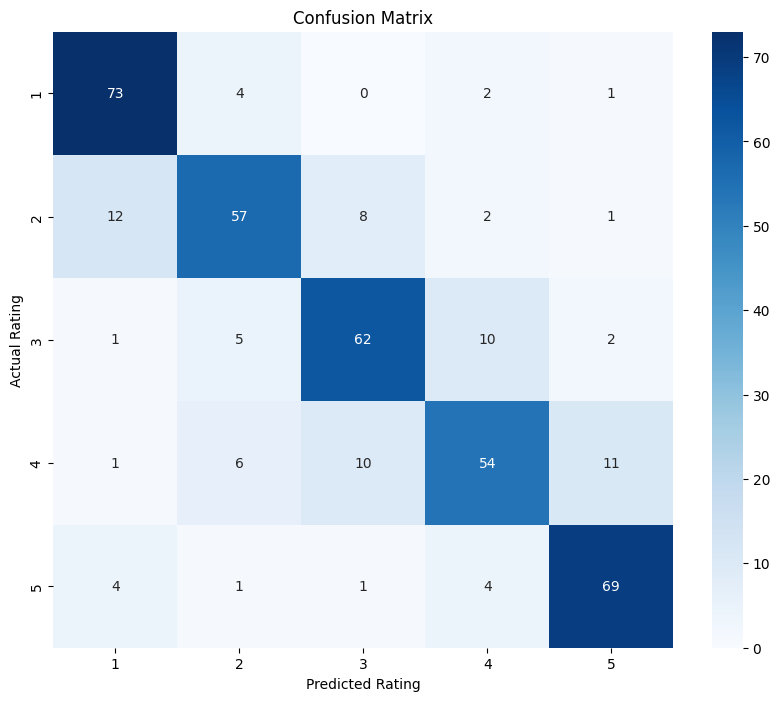

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix")

# บันทึกภาพ
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


## **11. Create Prediction Function**

In [ ]:
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create prediction function
def predict_review(text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Extract statistical features
    features = extract_features(cleaned_text)
    
    # Create Thai2fit vectors
    review_vector = enhanced_sentence_vectorizer(cleaned_text).reshape(1, -1)
    review_vector_sparse = csr_matrix(review_vector)
    review_vector_scaled = scaler.transform(review_vector_sparse)
    
    # Create TF-IDF vectors
    review_tfidf = tfidf_vectorizer.transform([cleaned_text])
    
    # Create Count vectors
    review_count = count_vectorizer.transform([cleaned_text])
    
    # Create statistical feature vectors
    additional_features = np.array([[
        features['exclamation_count'],
        features['question_count'],
        features['sentence_count'],
        features['word_count'],
        features['avg_word_length'],
        features['repeated_words_ratio'],
        features['negation_count'],
        features['punctuation_ratio'],
        features['text_length'],
        features['words_per_sentence']
    ]])
    
    additional_features_scaled = features_scaler.transform(additional_features)
    
    # Combine all features
    review_combined = hstack([
        review_tfidf,
        review_count,
        review_vector_scaled,
        csr_matrix(additional_features_scaled)
    ])
    
    # Predict class and probabilities
    predicted_class = model.predict(review_combined)[0]
    probabilities = model.predict_proba(review_combined)[0]
    
    return predicted_class, probabilities

## **12. Test with Real Reviews**

In [ ]:
# Test with example reviews
def print_prediction_results(
    text,
    actual_rating,
    model,
    tfidf_vectorizer,
    count_vectorizer,
    scaler,
    features_scaler,
):
    predicted_class, confidences = predict_review(
        text, model, tfidf_vectorizer, count_vectorizer, scaler, features_scaler
    )
    is_correct = int(predicted_class) == int(actual_rating)

    print(f"\nReview: {text[:100]}...")
    print(f"Actual rating: {actual_rating}/5")
    print(f"Predicted rating: {predicted_class}/5")
    print(f"Result: {'Correct' if is_correct else 'Incorrect'}")

    print("Confidence:")
    for rating, confidence in enumerate(confidences, 1):
        print(f"  Star {rating}: {confidence * 100:.1f}%")

    return predicted_class, int(actual_rating)


# ตัวอย่างรีวิวสำหรับทดสอบ
print("\nทดสอบโมเดลกับรีวิวสมจริง:")
test_reviews = [
    [
        "ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพังตั้งแต่วันแรกที่ย้ายเข้า เตียงก็เก่ามากนอนแล้วปวดหลัง ฝักบัวน้ำก็ไหลแค่ซิกๆ ไม่เคยมาซ่อมให้สักที ขอย้ายออกก็ไม่คืนเงินมัดจำ เสียความรู้สึกมากค่ะ",
        1,
    ],
    [
        "หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้องน้ำปิดไม่สนิท แล้วก็มีมดเยอะมาก ข้อดีคือใกล้ตลาด เดินไปซื้อของกินได้สะดวก แต่ภาพรวมยังไม่คุ้มค่าเท่าไหร่ ถ้ามีทางเลือกอื่นก็น่าจะดีกว่านะ",
        2,
    ],
    [
        "ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช้เยอะๆ กลางคืนมีเสียงดังรบกวนบ่อย เพื่อนบ้านก็เสียงดังด้วย ที่จอดรถก็แคบไปหน่อย บางทีก็หาที่จอดไม่ได้ อย่างน้อยก็ยังใกล้มหาลัยดี เดินไปเรียนได้สบาย",
        2,
    ],
    [
        "หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่นให้ ข้อเสียคือเสียงจากถนนดังมาก บางคืนนอนไม่ค่อยหลับ เน็ตช้าตอนคนใช้เยอะ กับข้าวที่โรงอาหารข้างล่างก็พอทานได้ ราคาไม่แพง สรุปคือโอเคสำหรับนักศึกษาที่งบไม่เยอะ",
        3,
    ],
    [
        "หอเปิดใหม่ สภาพห้องก็โอเคอยู่ค่ะ สะอาดดี มีตู้เย็นให้ แต่เฟอร์นิเจอร์น้อยไปหน่อย ต้องซื้อเองเพิ่ม ห้องน้ำก็ใช้ได้ ข้อเสียคือมีปัญหาน้ำไม่ค่อยไหลตอนเช้า บางทีต้องรอนาน เจ้าของหอก็พูดดี แต่แก้ปัญหาช้าไปหน่อย เพื่อนบ้านก็เงียบดี ไม่ค่อยมีเสียงดังรบกวน ถ้าปรับปรุงเรื่องน้ำได้คงจะดีขึ้น",
        3,
    ],
    [
        "ชอบหอนี้มากค่ะ ห้องกว้างสะอาด เฟอร์นิเจอร์ครบครัน แอร์เย็นฉ่ำ มีโต๊ะเครื่องแป้งด้วย สะดวกมาก อินเทอร์เน็ตเร็ว เล่นเกมสบาย เจ้าของหอใจดี มีอะไรแจ้งปุ๊บมาดูปั๊บ ข้อเสียเล็กๆคือค่าไฟค่อนข้างแพง แล้วก็ซักผ้าต้องลงไปชั้นล่าง อยากให้มีเครื่องซักผ้าทุกชั้น แต่โดยรวมพอใจมากค่ะ แนะนำเลย",
        4,
    ],
    [
        "ก่อนมาอยู่กังวลว่าจะไม่ดี ที่ไหนได้ดีมากๆเลยพี่ หอใหม่ ห้องสวยมากกกก มีระเบียงให้นั่งเล่น วิวดีด้วย ห้องกว้างขวาง แอร์เย็น ห้องน้ำสะอาด แถมมีเครื่องทำน้ำอุ่นด้วย เจ้าของหอน่ารักเป็นกันเอง เวลามีปัญหาอะไรแก้ไขให้เร็วมาก! ที่จอดรถกว้างขวาง มีรปภ. 24 ชม. รู้สึกปลอดภัยมาก ลบ 1 ดาวเพราะค่าไฟแพงไปนิด",
        4,
    ],
    [
        "หอนี้ดีที่สุดในย่านนี้แล้วว อยู่มา 3 ปีไม่เคยมีปัญหาเลย ห้องกว้าง สะอาด ตกแต่งสวย มีเฟอร์ครบ เหมือนอยู่คอนโด เน็ตไวมาก 100 Mbps เล่นเกมไม่มีสะดุด! ระบบรักษาความปลอดภัยแน่นมาก มีกล้องวงจรปิด คีย์การ์ดทุกชั้น และมี รปภ. 24 ชม. ทีเด็ดสุดคือมีฟิตเนสและสระว่ายน้ำให้ใช้ฟรี คุ้มมากกกก แนะนำสุดๆ ถ้าได้ห้องก็จองเลยอย่ารอ!",
        5,
    ],
    [
        "ไม่เคยรีวิวที่ไหน แต่หอนี้ต้องรีวิว! เพราะประทับใจมากๆ บรรยากาศดีงามม วิวสวยยย เหมือนรีสอร์ท มีสวนเล็กๆให้นั่งเล่น อยู่แล้วรู้สึกผ่อนคลาย ห้องกว้างสะอาด แอร์เย็นจนต้องปรับความแรงลง เฟอร์ใหม่หมด มีทีวี ตู้เย็น ไมโครเวฟให้ครบ เจ้าของหอใจดีที่สุด ให้ความช่วยเหลือตลอด มีกิจกรรมให้ทำด้วย อยู่แล้วมีความสุขมากๆ ถ้าใครกำลังหาหอ แนะนำที่นี่เลยย♥",
        5,
    ],
]

results = []
for review, actual_rating in test_reviews:
    predicted_rating, actual = print_prediction_results(
        review,
        actual_rating,
        lr_model,
        tfidf_vectorizer,
        count_vectorizer,
        scaler,
        features_scaler,
    )
    results.append((predicted_rating, actual))

correct_predictions = sum(1 for pred, actual in results if pred == actual)
accuracy = correct_predictions / len(results)

print("\nผลสรุปการทดสอบรีวิว:")
print(f"ทำนายถูกต้อง: {correct_predictions} รีวิว")
print(f"ทำนายผิดพลาด: {len(results) - correct_predictions} รีวิว")
print(f"ความแม่นยำรวม: {accuracy:.2f} ({correct_predictions}/{len(results)})")


ทดสอบโมเดลกับรีวิวสมจริง:

Review: ไม่แนะนำเลยค่ะ หอนี้ หลอกเอาเงินชัดๆ ในรูปสวยมาก แต่พอเข้าไปอยู่จริงสภาพห้องทรุดโทรมมาก ตู้เสื้อผ้าพ...
Actual rating: 1/5
Predicted rating: 1/5
Result: Correct
Confidence:
  Star 1: 97.7%
  Star 2: 2.3%
  Star 3: 0.0%
  Star 4: 0.0%
  Star 5: 0.0%

Review: หอพักราคาก็โอเคนะ ไม่แพงมาก แต่มีข้อเสียเยอะไปหน่อย ห้องเล็กเกินไป แอร์เสียงดังรบกวนเวลานอน ประตูห้อ...
Actual rating: 2/5
Predicted rating: 3/5
Result: Incorrect
Confidence:
  Star 1: 0.5%
  Star 2: 2.3%
  Star 3: 53.3%
  Star 4: 43.9%
  Star 5: 0.0%

Review: ก็...พออยู่ได้อ่ะ แต่ไม่ได้ดีมาก จ่ายค่าไฟแพงเกิน แอร์ทำงานไม่ค่อยดี นอนร้อนตลอด เน็ตช้ามากตอนมีคนใช...
Actual rating: 2/5
Predicted rating: 2/5
Result: Correct
Confidence:
  Star 1: 25.2%
  Star 2: 67.9%
  Star 3: 5.8%
  Star 4: 1.0%
  Star 5: 0.0%

Review: หอนี้โดยรวมก็โอเคนะครับ ไม่ได้แย่แต่ก็ไม่ได้ดีมาก ห้องกว้างพอสมควร แอร์ก็เย็นปกติ มีเครื่องทำน้ำอุ่น...
Actual rating: 3/5
Predicted rating: 2/5
Result: Incorrect
Confidence:
  Star 1: 1